<a href="https://colab.research.google.com/github/snehasharma0807/eeg-epilepsy/blob/main/commit_aug_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#install and import packages
!pip install ipython-autotime
%load_ext autotime
# !pip install mne
import tensorflow as tf
from tensorflow import keras
import os
# import mne
# from mne import create_info
# from mne.viz import plot_topomap
import numpy as np
import torch
import io
import matplotlib.pyplot as plt


In [ ]:
# @title Preprocessing Data: Functions
def getTimeFreqTopoData(EEG):
  times = []
  sec_increment = 10 * 60  # 10 minutes
  trange = np.arange(EEG.times[0], EEG.times[-1] + sec_increment, sec_increment)
  for i in np.arange(len(trange) - 1):
    times.append((trange[i], trange[i + 1]))

  bands = []
  frange = np.arange(80, 260, 10)  # Adjusted frequency range
  for i in np.arange(len(frange) - 1):
    bands.append((frange[i], frange[i + 1]))

  tf_topodata = []
  for t in times:
    print(t[0], '-', t[1])
    spectrum = EEG.compute_psd(tmin=t[0], tmax=t[1])
    freq_topodata = getTopoData(spectrum, bands)
    tf_topodata.append(freq_topodata)
  tf_topodata = np.stack(tf_topodata)
  return tf_topodata



def getTopoData(spectrum, bands):
  data = []
  for band in bands:
    data.append(getTopoBandData(spectrum, band))
  data = np.stack(data)
  return data

def getTopoBandData(spectrum, band):
  fig, ax1 = plt.subplots()
  fig.set_size_inches(2,2)
  spectrum.plot_topomap(axes=ax1, bands={'':band}, dB=True, cmap='gray', contours=0, outlines='head', sensors=False);
  fig.get_axes()[1].remove() #remove colorbar
  fig.get_axes()[0].set_title(None)

  with io.BytesIO() as buff:
    fig.savefig(buff, format='raw')
    buff.seek(0)
    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
  w, h = fig.canvas.get_width_height()
  im = data.reshape((int(h), int(w), -1))
  im = im[30:155, 25:150, 0]
  plt.close()
  return im

time: 1.47 ms (started: 2023-08-11 01:53:23 +00:00)


In [ ]:
# @title Preprocessing Data
subjects = ["24", "25", "26", "27", "28", "29", "30"]

for subj in subjects:
  #loading data
  sample_data_folder =("/content/drive/MyDrive/projectcode")
  sample_data_raw_file = os.path.join(sample_data_folder,'sub-'+ subj + '_ses-01_task-hfo_eeg.edf')
  raw = mne.io.read_raw_edf(sample_data_raw_file,preload = True)
  raw.load_data()

  #check channels
  print(raw.info.ch_names)
  raw.drop_channels(["A1", "A2", "Cz2", 'T1', 'T2'], on_missing = 'ignore')
  print(raw.info.ch_names)

  #resample data to 500 hz
  resampled = raw.resample(500)

  data = resampled.get_data()
  info = create_info(ch_names=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'], sfreq=500, ch_types='eeg')
  info.set_montage('standard_1020')

  EEG = mne.io.RawArray(data, info)

  tf_topodata = getTimeFreqTopoData(EEG)  # output shape = [# time windows X # freq bands X # vert pixels X # horz pixels]
  print(tf_topodata.shape)
  output_directory = "/content/drive/MyDrive/projectcode/newtensors/"
  tftopo_fileName =str(subj) + '_tf_topodata.tensor'
  output = os.path.join(output_directory, tftopo_fileName)
  torch.save(tf_topodata, output)
  EEG = None
  tf_topodata = None
  raw = None
  resampled = None

  print("Done with " + subj)

In [66]:
# @title Getting Data Ready for ML
import torch

def getTensorFromFile(subject):
  tftopo_fileName = "/content/drive/MyDrive/projectcode/newtensors/"+subject+"_tf_topodata.tensor"
  tf_topodata = torch.load(tftopo_fileName)
  return tf_topodata


subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"]

tensors = [getTensorFromFile(subj) for subj in subjects]
tensors[12], tensors[19], tensors[29] = tensors[12][:-1, :, :, :], tensors[19][:-1, :, :, :], tensors[29][:-1, :, :, :]

#right shape
tensors = [np.transpose(t, (0, 2, 3, 1)) for t in tensors]

#normalize data
tensors = [t.astype("float32")/255.0 for t in tensors]

#convert into correct shape
data = [array[:, 0:, :, :] for array in tensors]
data = np.concatenate(data, axis=0) #np.stack

print(data.shape)
print(len(tensors))
print(tensors[0].shape)

(535, 125, 125, 17)
30
(18, 125, 125, 17)
time: 2.19 s (started: 2023-08-22 00:46:58 +00:00)


In [68]:
# @title Dimensionality Reduction With PCA

from sklearn.decomposition import PCA

all_reduced = []
for t in tensors:
  #reshape each tensor for pca
  times, h, w, channels = t.shape
  reshaped = t.reshape(times * h * w, channels)

  #initialize pca
  pca = PCA(n_components=3)

  #reshape data for future use
  reduced = pca.fit_transform(reshaped)
  reshaped_reduced = reduced.reshape(times, h, w, 3)
  all_reduced.append(reshaped_reduced)

#concatenate everything for future cnn use
for_cnn = np.concatenate(all_reduced, axis=0)
print(for_cnn.shape)

(535, 125, 125, 3)
time: 22.7 s (started: 2023-08-22 00:47:14 +00:00)


In [69]:
# @title Feature Extraction with CNN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# load vgg model
base_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(125, 125, 3))

# create model with new output (outputs will be features extracted)
feature_extractor = Model(inputs=base_vgg.input, outputs=Flatten()(base_vgg.output))

# extract features
features = feature_extractor.predict(for_cnn)

print(features.shape)

17/17 [==============================] - 125s 7s/step
(535, 4608)
time: 2min 6s (started: 2023-08-22 00:47:44 +00:00)


In [70]:
# @title KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=20, random_state=0)
cluster_assignments = kmeans.fit_predict(features)
print(cluster_assignments.shape)
x = cluster_assignments[:180]
x = x.reshape((10, 18))
print(x)

(535,)
[[1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1]
 [1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1]
 [0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1]
 [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0]]
time: 4.35 s (started: 2023-08-22 00:50:29 +00:00)


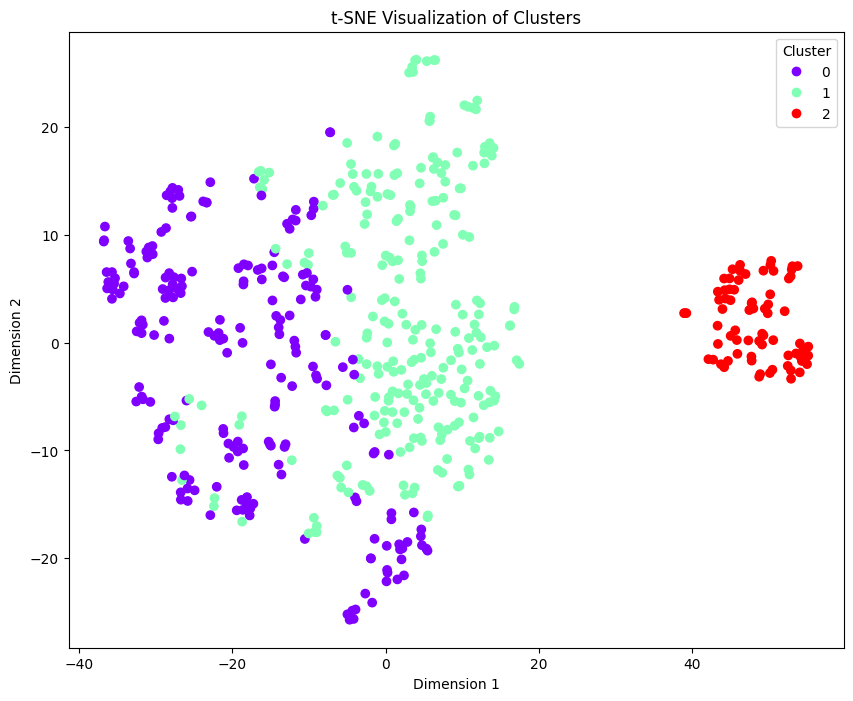

time: 6.95 s (started: 2023-08-22 00:50:56 +00:00)


In [72]:
# @title Visualize Clusters with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'features' are your extracted features and 'cluster_assignments' are the cluster labels

tsne = TSNE(n_components=2, random_state=0)  # Use n_components=2 for 2D visualization
embedded_data = tsne.fit_transform(features)

# Create a scatter plot in 2D with cluster coloring
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_assignments, cmap='rainbow')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Add colorbar
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

plt.show()

In [50]:
data = np.transpose(data, (0, 2, 3, 1))
print(data.shape)

(535, 17, 125, 125)
time: 27.3 ms (started: 2023-08-22 00:15:38 +00:00)


0
1
2


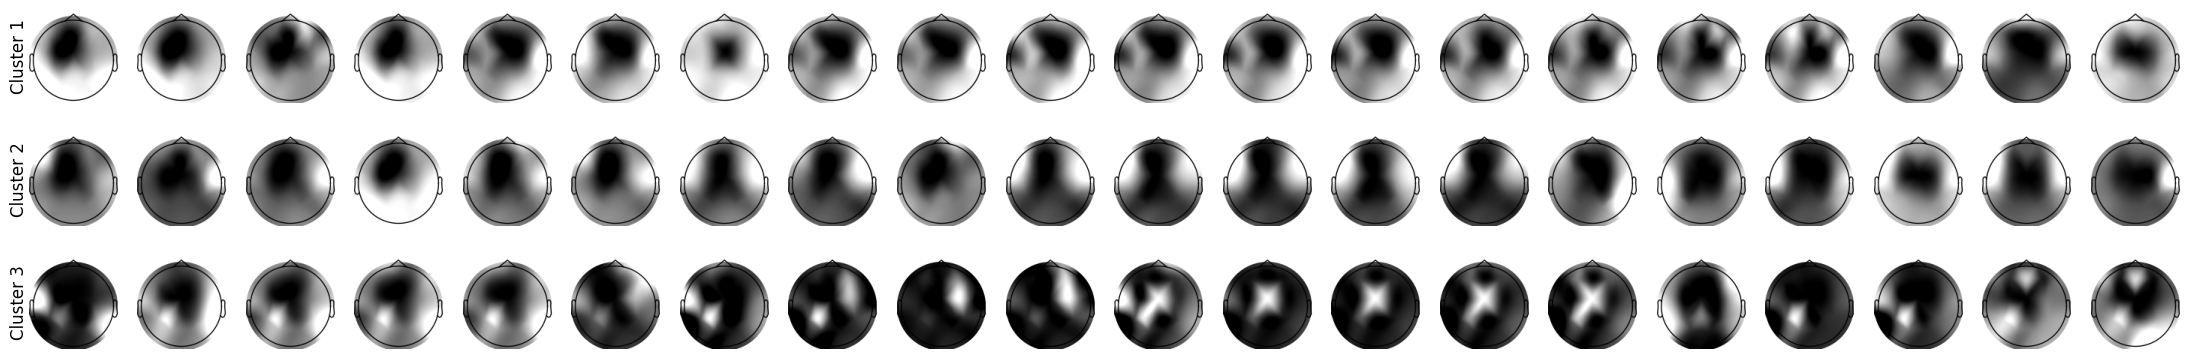

time: 2.78 s (started: 2023-08-22 00:50:37 +00:00)


In [71]:
# @title View Images in Each Cluster
num_clusters = 3

fig, axes = plt.subplots(num_clusters, 20, figsize=(22, 4))
for cluster_num in range(num_clusters):
    # find indices of data points in the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    print(cluster_num)
    # show 5 images from each cluster
    for i, idx in enumerate(cluster_indices[:20]):
        ax = axes[cluster_num, i]
        image = data[idx, :, :, 0]
        ax.imshow(image, cmap='gray')
        ax.axis('off')


# label each cluster
for r in range(num_clusters):
    ax = axes[r, 0]
    ax.text(-0.2, 0.5, f'Cluster {r + 1}', transform=ax.transAxes,
            rotation=90, va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()